# AC290 EXTREME COMPUTING

### Bleeding Edge

### Gioia Dominedo, Christian Junge, Abhishek Malali and Isadora Nun

## Overall results:

**NC_mini (greedy algorithm with N=1,000):**

Starting nodes: [u'NzWLMPvbEval0OVg_YDn4g', u'VhI6xyylcAxi0wOy2HOX3w', u'-_1ctLaz3jhPYc12hKXsEQ']

Average activated nodes: 46.45

**NC_full (greedy algorithm with N=300):**

Starting nodes: [u'55GXsFLH4QYnTQqiijBtxA', u'HrBHqWQiP6YfGexLwAdzqQ', u'rTvFiQSg_cLHejrT1jA0UA']

Average activated nodes: 8979.96

**US:** [todo]

## Key functions

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import time
import numpy as np
from numpy import random
import math
import scipy
from scipy import stats
from random import choice
import networkx as nx
import json
from networkx.readwrite import json_graph
import line_profiler
import IPython
ip = IPython.get_ipython()
ip.define_magic('lprun', line_profiler.magic_lprun)

In [3]:
import findspark
import os
findspark.init()
# import pyspark
# sc = pyspark.SparkContext()

In [4]:
with open("graph/nc_mini.json", "r") as graph_data_mini:
    graph_data_mini = json.load(graph_data_mini)
    NC_digraph_mini = json_graph.node_link_graph(graph_data_mini)
    
with open("graph/nc_full.json", "r") as graph_data_full:
    graph_data_full = json.load(graph_data_full)
    NC_digraph_full = json_graph.node_link_graph(graph_data_full)

In [5]:
def print_graph(Graph, S1=None):
    """
    Prints a representation of the NetworkX graph.
    """
    plt.figure(figsize=(16,10))
    color_map = {1: 'b', 0: 'r'}
    pos = nx.random_layout(Graph)
    
    if S1:
        nx.draw_networkx(Graph, pos, with_labels=False, node_size=100, node_shape='.',
                linewidth=None, width=0.2, edge_color='y', 
                node_color=[color_map[Graph.node[node]['action']] for node in Graph],
                edgelist=reduce(lambda x,y: x+y,[Graph.edges(node) for node in S1]))
        nx.draw_networkx_nodes(Graph, pos, nodelist=S1, node_color="b", node_size=150, 
                              node_shape="*", label="Initial Set")
        plt.legend()
    else:
        nx.draw_networkx(Graph, pos, with_labels=False, node_size=100, node_shape='.',
                linewidth=None, width=0.2, edge_color='y', 
                 node_color=[color_map[Graph.node[node]['action']] for node in Graph])
        
    plt.xlim(-0.05,1.05)
    plt.ylim(-0.05,1.05)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [6]:
def influenceFunction(graph, detStartNodes, t=999999):
    """
    Determines the number of nodes that are activated from pre-specified starting nodes.

    Inputs:
    graph: the NetworkX graph that is explored in the function
    detStartNodes: a list of pre-specific starting nodes
    t: the maximum depth explored from the starting nodes

    Outputs: the number of activated nodes
    """
    
    explored = set()
    activated = set()
    nodes = []
    for node in detStartNodes:
        nodes.append(node)
        activated.add(node)
    
    start = detStartNodes[0]
    successors = []

    for i in range(t):
        successors = []
        while len(nodes)>0:
            startNode = nodes[0]
            if startNode not in explored:
                explored.add(startNode)
            for succNode in graph.succ[startNode]:
                if succNode not in activated:
                    alpha = graph[startNode][succNode]['weight']
                    beta = graph.node[succNode]['review_count']
                    if random.uniform(0,1) < np.sqrt(random.beta(alpha, beta)):
                        if succNode not in explored:
                            activated.add(succNode)
                            successors.append(succNode)
            nodes.remove(startNode)
        nodes = successors
        if not nodes:
            break
    return float(len(activated))

In [7]:
def influenceFunctionNotParDetStart(graph, detStartNodes, N, t=999999):
    """
    Determines the average number of nodes that are activated in N runs of
    the influence function from pre-specified starting nodes.
    The calculation in run serially.

    Inputs:
    graph: the NetworkX graph that is explored in the function
    detStartNodes: a list of pre-specific starting nodes
    N: the number of iterations of the influence function that are run per node(s)
    t: the maximum depth explored from the starting nodes

    Outputs: the average number of activated nodes
    """
    result = []
    for n in xrange(N):
        result.append(float(influenceFunction(graph, detStartNodes, t)))
    return np.mean(result)

In [8]:
def influenceFunctionParDetStart(graph, detStartNodes, N, t=999999):
    """
    Determines the average number of nodes that are activated in N runs of
    the influence function from pre-specified starting nodes.
    The calculation is run in parallel using Spark.

    Inputs:
    graph: the NetworkX graph that is explored in the function
    detStartNodes: a list of pre-specific starting nodes
    N: the number of iterations of the influence function that are run per node(s)
    t: the maximum depth explored from the starting nodes

    Outputs: the average number of activated nodes
    """
    runs = sc.parallelize(range(N), 4)
    results = runs.map(lambda x: influenceFunction(graph, detStartNodes, t))
    return np.mean(results.collect())

In [9]:
def influenceFunctionNotParRandStart(graph, N, t=999999):
    """
    Determines the average number of nodes that are activated in N runs of
    the influence function from random starting nodes.
    The calculation in run serially.

    Inputs:
    graph: the NetworkX graph that is explored in the function
    detStartNodes: a list of pre-specific starting nodes
    N: the number of iterations of the influence function that are run per node
    t: the maximum depth explored from the starting nodes

    Outputs: the average number of activated nodes
    """
    result = []
    for n in xrange(N):
        result.append(float(influenceFunction(graph, [random.choice(graph.nodes(),1)[0]], t)))
    return np.mean(result)

In [10]:
def influenceFunctionParRandStart(graph, N, t=999999):
    """
    Determines the average number of nodes that are activated in N runs of
    the influence function from random starting nodes.
    The calculation is run in parallel using Spark.

    Inputs:
    graph: the NetworkX graph that is explored in the function
    detStartNodes: a list of pre-specific starting nodes
    N: the number of iterations of the influence function that are run per node
    t: the maximum depth explored from the starting nodes

    Outputs: the average number of activated nodes
    """
    runs = sc.parallelize(range(N), 4)
    results = runs.map(lambda x: influenceFunction(graph, [random.choice(graph.nodes(),1)[0]], t))
    return np.mean(results.collect())

In [11]:
def greedySearch(graph, k=3, N=1000, t=999999):
    """
    In each of k iterations, determines that start node that results in the most
    activated nodes when combined with the output of the previous iterations.
    The calculation is run in parallel using Spark.

    Inputs:
    graph: the NetworkX graph that is explored in the function
    k: the number of starting nodes that are returned
    N: the number of iterations of the influence function that are run per node(s)
    t: the maximum depth explored from the starting nodes

    Outputs: the k nodes that result in the most activations, and
    the number of nodes that they activate when run as starting nodes
    """    
    best_s = []
    max_inf = 0
    nodeRDD = sc.parallelize(list(set(list(sum(graph.edges(), ())))), 4)
    
    for i in range(k):
        infRDD = nodeRDD.map(lambda n: (n, 0.) if n in best_s else \
                             (n, influenceFunctionNotParDetStart(graph, best_s + [n], N, t)))
        next_s, next_i = infRDD.reduce(lambda a,b: a if a[1] > b[1] else b)
        best_s += [next_s]
        max_inf = next_i
    
    return best_s, max_inf

In [12]:
def maxEdges(graph, k=3):
    """
    Heuristic function: determines the k nodes in the graph with the most edges.

    Inputs:
    graph: the NetworkX graph that is explored in the function
    k: the number of nodes that are returned

    Outputs: the k nodes with the most edges
    """      
    nodeRDD = sc.parallelize(list(set(list(sum(graph.edges(), ())))), 4)   
    infRDD = nodeRDD.map(lambda n: (n, len(graph.succ[n])))
    return infRDD.takeOrdered(k, lambda w: -w[1])

In [13]:
def maxNodes(graph, k=3, N=1000, t=999999):
    """
    Heuristic function: determines the k nodes in the graph that activate the most nodes
    when run as independent starting nodes.

    Inputs:
    graph: the NetworkX graph that is explored in the function
    k: the number of nodes that are returned
    N: the number of iterations of the influence function that are run per node
    t: the maximum depth explored from the starting nodes

    Outputs: the k nodes with the most edges
    """     
    nodeRDD = sc.parallelize(list(set(list(sum(graph.edges(), ())))), 4)   
    infRDD = nodeRDD.map(lambda n: (n, influenceFunctionNotParDetStart(graph, [n], N)))
    return infRDD.takeOrdered(k, lambda w: -w[1])

## Part 1: Influence function

### Original specification:

In [13]:
def activateNodes(detStart, detRandSeed):
    """
    These are early versions of influenceFunction and influenceFunctionNotParRandStart.
    Compared to the final versions, these allowed us to specify seeds for our random number
    generators in order to compare our function outputs. This functionality was removed
    from the final versions of the functions.
    """ 
    nx.set_node_attributes(NC_digraph_mini, 'activated', False)
    nx.set_node_attributes(NC_digraph_mini, 'explored', False)
    
    if detStart is None:
        if detRandSeed is not None:
            random.seed()
        start = random.choice(NC_digraph_mini.nodes(), 1)
    else:
        start = detStart
    
    nodes = [start[0]]

    activated = 1
    
    NC_digraph_mini.node[start[0]]['activated'] = True
    
    while len(nodes)>0:

        startNode = nodes[0]

        if NC_digraph_mini.node[startNode]['explored']==False:

            NC_digraph_mini.node[startNode]['explored'] = True

            successors = []

            for succNode in NC_digraph_mini.succ[startNode]:

                if NC_digraph_mini.node[succNode]['activated']==False:

                    alpha = NC_digraph_mini[startNode][succNode]['weight']
                    beta = NC_digraph_mini.node[succNode]['review_count']

                    if detRandSeed is not None:
                        random.seed(detRandSeed)
                    randUnif = random.uniform(0,1)
                    if detRandSeed is not None:
                        random.seed(detRandSeed)
                    randBeta = np.sqrt(random.beta(alpha, beta))

                    if randUnif < randBeta:
                        NC_digraph_mini.node[succNode]['activated'] = True
                        successors.append(succNode)
                        activated = activated + 1

        nodes = nodes[1:]
        nodes = nodes + successors

    return activated

def activateNodesLoop(N, rootSeed=None, randNumSeed=None):
    
    if rootSeed is not None and randNumSeed is not None:
        random.seed(rootSeed) 
        detStart = random.choice(NC_digraph_mini.nodes(), 1) # deterministic start node
        detRandSeed = randNumSeed # deterministic random variables
    elif rootSeed is None and randNumSeed is None:
        random.seed()
        detStart = None # stochastic start node
        detRandSeed = None # stochastic random variables
    elif rootSeed is not None and randNumSeed is None:
        random.seed(rootSeed) 
        detStart = random.choice(NC_digraph_mini.nodes(), 1) # deterministic start node
        random.seed()
        detRandSeed = None # stochastic random variables
    elif rootSeed is None and randNumSeed is not None:
        detStart = None # stochastic start node
        detRandSeed = randNumSeed # deterministic random variables

    result = []

    for n in xrange(N):
        result.append(float(activateNodes(detStart, detRandSeed)))
        
    return result

1) Test results with given starting parameters:

In [14]:
assert activateNodesLoop(N=1, rootSeed=9, randNumSeed=9)[0] == 141
assert activateNodesLoop(N=1, rootSeed=12, randNumSeed=12)[0] == 1
assert activateNodesLoop(N=1, rootSeed=24, randNumSeed=12)[0] == 4

2) Test mean and standard deviation (should be ~9.5 and ~14):

9.882000 mean, 14.892148 standard deviation


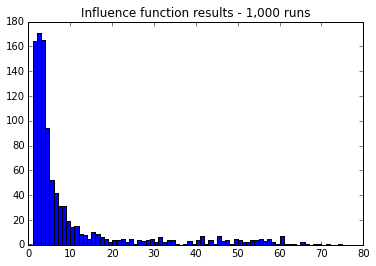

In [30]:
result = activateNodesLoop(N=1000, rootSeed=24, randNumSeed=None)
print '%f mean, %f standard deviation' % (np.mean(result), np.std(result))
plt.hist(result, bins=range(int(max(result))))
plt.title('Influence function results - 1,000 runs')
plt.show()

3) Check runtime and profile code:

In [16]:
%time result = activateNodesLoop(N=1000, rootSeed=24, randNumSeed=None)

CPU times: user 504 ms, sys: 13.8 ms, total: 518 ms
Wall time: 583 ms


In [17]:
%lprun -f activateNodes result = activateNodesLoop(N=1000, rootSeed=24, randNumSeed=None)

### Final specification:

1) Check runtime for various graph/function combinations:

**NC_mini**

In [14]:
NC_digraph_mini.number_of_nodes()

240

In [15]:
# Influence function for given start nodes
start = ['NzWLMPvbEval0OVg_YDn4g','ts7EG6Zv2zdMDg29nyqGfA','VhI6xyylcAxi0wOy2HOX3w']
noRuns = 100

print "No cap on t (serial):"
startTime = time.time()
influenceFunctionNotParDetStart(NC_digraph_mini, start, noRuns)
runTime = time.time() - startTime
print '%f seconds run time' % (runTime)

print "\nt capped at 10 (serial):"
startTime = time.time()
influenceFunctionNotParDetStart(NC_digraph_mini, start, noRuns, 10)
runTime = time.time() - startTime
print '%f seconds run time' % (runTime)

print "\nNo cap on t (parallel):"
startTime = time.time()
influenceFunctionParDetStart(NC_digraph_mini, start, noRuns)
runTime = time.time() - startTime
print '%f seconds run time' % (runTime)

print "\nt capped at 10 (parallel):"
startTime = time.time()
influenceFunctionParDetStart(NC_digraph_mini, start, noRuns, 10)
runTime = time.time() - startTime
print '%f seconds run time' % (runTime)

No cap on t (serial):
2.314315 seconds run time

t capped at 10 (serial):
0.109237 seconds run time

No cap on t (parallel):
4.675723 seconds run time

t capped at 10 (parallel):
0.188344 seconds run time


In [16]:
# Influence function for random start nodes
noRuns = 100

print "No cap on t (serial):"
startTime = time.time()
influenceFunctionNotParRandStart(NC_digraph_mini, noRuns)
runTime = time.time() - startTime
print '%f seconds run time' % (runTime)

print "\nt capped at 10 (serial):"
startTime = time.time()
influenceFunctionNotParRandStart(NC_digraph_mini, noRuns, 10)
runTime = time.time() - startTime
print '%f seconds run time' % (runTime)

print "\nno cap on t (parallel):"
startTime = time.time()
influenceFunctionParRandStart(NC_digraph_mini, noRuns)
runTime = time.time() - startTime
print '%f seconds run time' % (runTime)

print "\nt capped at 10 (parallel):"
startTime = time.time()
influenceFunctionParRandStart(NC_digraph_mini, noRuns, 10)
runTime = time.time() - startTime
print '%f seconds run time' % (runTime)

No cap on t (serial):
1.985098 seconds run time

t capped at 10 (serial):
0.012085 seconds run time

no cap on t (parallel):
1.457023 seconds run time

t capped at 10 (parallel):
0.131977 seconds run time


In [17]:
# Influence function for random start nodes
noRuns = 1000

print "No cap on t (serial):"
startTime = time.time()
influenceFunctionNotParRandStart(NC_digraph_mini, noRuns)
runTime = time.time() - startTime
print '%f seconds run time' % (runTime)

print "\nt capped at 10 (serial):"
startTime = time.time()
influenceFunctionNotParRandStart(NC_digraph_mini, noRuns, 10)
runTime = time.time() - startTime
print '%f seconds run time' % (runTime)

print "\nno cap on t (parallel):"
startTime = time.time()
influenceFunctionParRandStart(NC_digraph_mini, noRuns)
runTime = time.time() - startTime
print '%f seconds run time' % (runTime)

print "\nt capped at 10 (parallel):"
startTime = time.time()
influenceFunctionParRandStart(NC_digraph_mini, noRuns, 10)
runTime = time.time() - startTime
print '%f seconds run time' % (runTime)

No cap on t (serial):
19.604031 seconds run time

t capped at 10 (serial):
0.119819 seconds run time

no cap on t (parallel):
10.973880 seconds run time

t capped at 10 (parallel):
0.187697 seconds run time


**NC_full**

In [18]:
NC_digraph_full.number_of_nodes()

24224

In [19]:
# Influence function for given start nodes
start = ['NzWLMPvbEval0OVg_YDn4g','ts7EG6Zv2zdMDg29nyqGfA','VhI6xyylcAxi0wOy2HOX3w']
noRuns = 100

print "No cap on t (serial):"
startTime = time.time()
influenceFunctionNotParDetStart(NC_digraph_full, start, noRuns)
runTime = time.time() - startTime
print '%f seconds run time' % (runTime)

print "\nt capped at 10 (serial):"
startTime = time.time()
influenceFunctionNotParDetStart(NC_digraph_full, start, noRuns, 10)
runTime = time.time() - startTime
print '%f seconds run time' % (runTime)

print "\nno cap on t (parallel):"
startTime = time.time()
influenceFunctionParDetStart(NC_digraph_full, start, noRuns)
runTime = time.time() - startTime
print '%f seconds run time' % (runTime)

print "\nt capped at 10 (parallel):"
startTime = time.time()
influenceFunctionParDetStart(NC_digraph_full, start, noRuns, 10)
runTime = time.time() - startTime
print '%f seconds run time' % (runTime)

No cap on t (serial):
13.284066 seconds run time

t capped at 10 (serial):
9.755757 seconds run time

no cap on t (parallel):
11.009843 seconds run time

t capped at 10 (parallel):
8.885949 seconds run time


In [20]:
# Influence function for random start nodes
noRuns = 100

print "No cap on t (serial):"
startTime = time.time()
influenceFunctionNotParRandStart(NC_digraph_full, noRuns)
runTime = time.time() - startTime
print '%f seconds run time' % (runTime)

print "\nt capped at 10 (serial):"
startTime = time.time()
influenceFunctionNotParRandStart(NC_digraph_full, noRuns, 10)
runTime = time.time() - startTime
print '%f seconds run time' % (runTime)

print "\nno cap on t (parallel):"
startTime = time.time()
influenceFunctionParRandStart(NC_digraph_full, noRuns)
runTime = time.time() - startTime
print '%f seconds run time' % (runTime)

print "\nt capped at 10 (parallel):"
startTime = time.time()
influenceFunctionParRandStart(NC_digraph_full, noRuns, 10)
runTime = time.time() - startTime
print '%f seconds run time' % (runTime)

No cap on t (serial):
10.352598 seconds run time

t capped at 10 (serial):
3.170654 seconds run time

no cap on t (parallel):
6.321508 seconds run time

t capped at 10 (parallel):
5.098914 seconds run time


In [21]:
# Influence function for random start nodes
noRuns = 1000

print "No cap on t (serial):"
startTime = time.time()
influenceFunctionNotParRandStart(NC_digraph_full, noRuns)
runTime = time.time() - startTime
print '%f seconds run time' % (runTime)

print "\nt capped at 10 (serial):"
startTime = time.time()
influenceFunctionNotParRandStart(NC_digraph_full, noRuns, 10)
runTime = time.time() - startTime
print '%f seconds run time' % (runTime)

print "\nno cap on t (parallel):"
startTime = time.time()
influenceFunctionParRandStart(NC_digraph_full, noRuns)
runTime = time.time() - startTime
print '%f seconds run time' % (runTime)

print "\nt capped at 10 (parallel):"
startTime = time.time()
influenceFunctionParRandStart(NC_digraph_full, noRuns, 10)
runTime = time.time() - startTime
print '%f seconds run time' % (runTime)

No cap on t (serial):
93.035441 seconds run time

t capped at 10 (serial):
21.727238 seconds run time

no cap on t (parallel):
24.502935 seconds run time

t capped at 10 (parallel):
15.930457 seconds run time


2) Determine variation in results as a function of N:

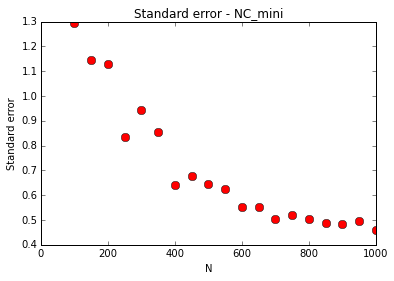

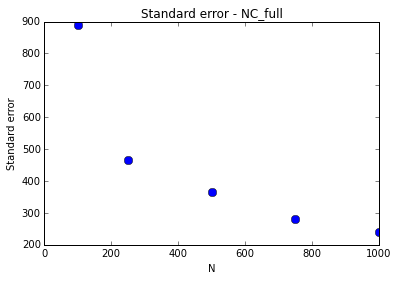

In [14]:
# Results are pre-calculated and loaded here

# Load results for NC_mini
stdErrMini = dict()
for k in range(100,1050,50):
    with open("data/SE-NC_mini-N=" + str(k) + ".json", "r") as fd:
        results = json.load(fd)
    stdErrMini[k] = np.std(results)

# Load results for NC_full
stdErrFull = dict()
for k in [100, 250, 500, 750, 1000]:
    with open("data/SE-NC_full-N=" + str(k) + ".json", "r") as fd:
        results = json.load(fd)
    stdErrFull[k] = np.std(results)
    
plt.plot(stdErrMini.keys(), stdErrMini.values(), 'o-', color='r', linestyle='None', markersize=8, label="NC_mini")
plt.title('Standard error - NC_mini')
plt.xlabel('N')
plt.ylabel('Standard error')
plt.xlim(xmin=0, xmax=1000)
plt.show()

plt.plot(stdErrFull.keys(), stdErrFull.values(), 'o-', color='b', linestyle='None', markersize=8, label="NC_full")
plt.title('Standard error - NC_full')
plt.xlabel('N')
plt.ylabel('Standard error')
plt.xlim(xmin=0, xmax=1000)
plt.show()

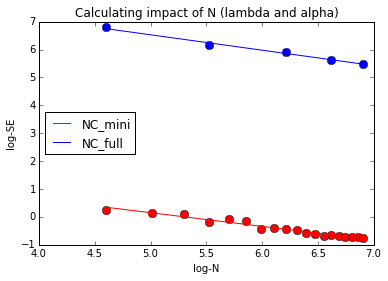

NC_mini:
lambda = 0.490183
alpha = 13.485154

NC_full:
lambda = 0.551575
alpha = 10774.771915


In [15]:
yMini = [math.log(i) for i in stdErrMini.values()]
xMini = [math.log(i) for i in stdErrMini.keys()]
slopeMini, interceptMini, r_valueMini, p_valueMini, std_errMini = scipy.stats.linregress(xMini, yMini)
keysMini = [math.log(i) for i in stdErrMini.keys()]
keysMini.sort()
solutionMini = [interceptMini + slopeMini*n for n in keysMini]

yFull = [math.log(i) for i in stdErrFull.values()]
xFull = [math.log(i) for i in stdErrFull.keys()]
slopeFull, interceptFull, r_valueFull, p_valueFull, std_errFull = scipy.stats.linregress(xFull, yFull)
keysFull = [math.log(i) for i in stdErrFull.keys()]
keysFull.sort()
solutionFull = [interceptFull + slopeFull*n for n in keysFull]

plt.plot(xMini, [math.log(i) for i in stdErrMini.values()], 'o-', color='r', linestyle='None', markersize=8)
plt.plot(keysMini, solutionMini, color='r', label='NC_mini')
plt.plot(xFull, [math.log(i) for i in stdErrFull.values()], 'o-', color='b', linestyle='None', markersize=8)
plt.plot(keysFull, solutionFull, color='b', label='NC_full')
plt.title('Calculating impact of N (lambda and alpha)')
plt.xlabel('log-N')
plt.ylabel('log-SE')
plt.xlim(xmin=4, xmax=7)
plt.ylim(ymin=-1, ymax=7)
plt.legend(loc='center left')
plt.show()

print 'NC_mini:'
print 'lambda = %f' % (-slopeMini)
print 'alpha = %f' % (math.exp(interceptMini))

print '\nNC_full:'
print 'lambda = %f' % (-slopeFull)
print 'alpha = %f' % (math.exp(interceptFull))

## Part 2: Greedy algorithm

1) Check runtime:

In [13]:
# Greedy algorithm
noRuns = 1

print "No cap on t:"
startTime = time.time()
greedySearch(NC_digraph_mini, 3, noRuns)
runTime = time.time() - startTime
print '%f seconds run time' % (runTime)

print "\nt capped at 10:"
startTime = time.time()
greedySearch(NC_digraph_mini, 3, noRuns, 10)
runTime = time.time() - startTime
print '%f seconds run time' % (runTime)

No cap on t:
6.347991 seconds run time

t capped at 10:
4.359877 seconds run time


In [13]:
# Greedy algorithm
noRuns = 1

print "No cap on t:"
startTime = time.time()
greedySearch(NC_digraph_full, 3, noRuns)
runTime = time.time() - startTime
print '%f seconds run time' % (runTime)

print "\nt capped at 10:"
startTime = time.time()
greedySearch(NC_digraph_full, 3, noRuns, 10)
runTime = time.time() - startTime
print '%f seconds run time' % (runTime)

No cap on t:
1597.580273 seconds run time

t capped at 10:
1378.013352 seconds run time


2) Compare results for N = 100, 250, 500, 750, 1,000:

In [17]:
# Results are pre-calculated and loaded here
noRuns = 30

delta_graph_axis = []
delta_graph_data = []

axis_plot = dict()
results_plot = dict()
f_min = dict()
f_max = dict()

for greedyN in [100, 250, 500, 750, 1000]:
    
    with open("data/greedy-" + str(noRuns) + "x-N=" + str(greedyN) + ".json", "r") as fd:
        results = json.load(fd)
        
    # For delta graph
    actNodes = [r[1][1] for r in results]
    delta_graph_axis.append(greedyN)
    delta_graph_data.append(min(actNodes)/max(actNodes))
    
    # For scatter plot
    axis_plot[greedyN] = [r[0] for r in results]
    results_plot[greedyN] = [r[1][1] for r in results]
    f_min[greedyN] = min(results_plot[greedyN])
    f_max[greedyN] = max(results_plot[greedyN])

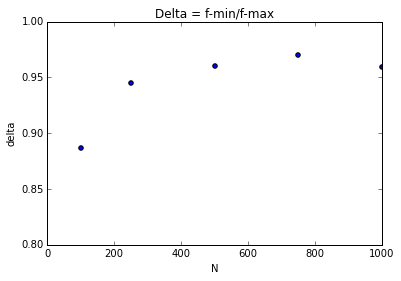

In [18]:
plt.scatter(delta_graph_axis, delta_graph_data)
plt.xlim(0, 1000)
plt.ylim(0.8, 1)
plt.xlabel('N')
plt.ylabel('delta')
plt.title('Delta = f-min/f-max')
plt.show()

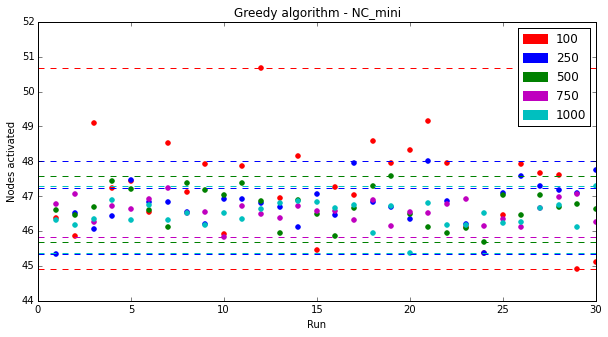

In [19]:
fig = plt.figure(figsize=(10, 5))

# Scatter plots
plt.scatter(axis_plot[100], results_plot[100], color='r')
plt.scatter(axis_plot[250], results_plot[250], color='b')
plt.scatter(axis_plot[500], results_plot[500], color='g')
plt.scatter(axis_plot[750], results_plot[750], color='m')
plt.scatter(axis_plot[1000], results_plot[1000], color='c')

# Min lines
plt.plot([0, 30], [f_min[100], f_min[100]], color='r', ls="--")
plt.plot([0, 30], [f_min[250], f_min[250]], color='b', ls="--")
plt.plot([0, 30], [f_min[500], f_min[500]], color='g', ls="--")
plt.plot([0, 30], [f_min[750], f_min[750]], color='m', ls="--")
plt.plot([0, 30], [f_min[1000], f_min[1000]], color='c', ls="--")

# Max lines
plt.plot([0, 30], [f_max[100], f_max[100]], color='r', ls="--")
plt.plot([0, 30], [f_max[250], f_max[250]], color='b', ls="--")
plt.plot([0, 30], [f_max[500], f_max[500]], color='g', ls="--")
plt.plot([0, 30], [f_max[750], f_max[750]], color='b', ls="--")
plt.plot([0, 30], [f_max[1000], f_max[1000]], color='c', ls="--")

# Legend
N100 = mpatches.Patch(color='r', label='100')
N250 = mpatches.Patch(color='b', label='250')
N500 = mpatches.Patch(color='g', label='500')
N750 = mpatches.Patch(color='m', label='750')
N1000 = mpatches.Patch(color='c', label='1000')
plt.legend(handles=[N100, N250, N500, N750, N1000])

plt.ylim(44, 52)
plt.xlim(0, 30)
plt.xlabel('Run')
plt.ylabel('Nodes activated')
plt.title('Greedy algorithm - NC_mini')

plt.show()

## Part 3: Simulated annealing

###Traveling Salesman

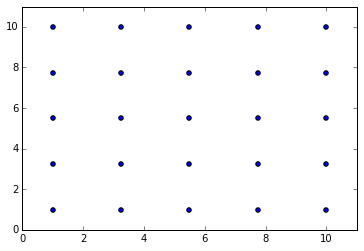

In [4]:
# Generate 25 Cities on 2D Euclidean Plane
x = np.linspace(1,10,5)
y = np.linspace(1,10,5)
tmpx, tmpy =  np.meshgrid(x,y)

cities = np.array([tmpx, tmpy])
cities = np.reshape(cities, (2,-1)).T

plt.scatter(cities[:,0], cities[:,1])
plt.xlim(0,11)
plt.ylim(0,11)
plt.show()

In [5]:
def plot_path(pcities):
    plt.plot(pcities[1:,0], pcities[1:,1],'o')
    plt.plot(pcities[:,0], pcities[:,1])
    plt.plot(pcities[0,0], pcities[0,1], '^')
    plt.xlim(np.min(pcities[:,0])-1, np.max(pcities[:,0])+1)
    plt.ylim(np.min(pcities[:,1])-1, np.max(pcities[:,1])+1)

In [6]:
# Helper Function 
def swapindex(cities):
    indices = range(len(cities))
    # take two random indices to swap
    c1,c2 = np.random.choice(indices, 2, replace=False)
    
    # remember the cities to swap
    tmp1 = cities[c1,:]
    tmp2 = cities[c2,:]
    
    # do the actual swapping
    changedCities = cities.copy()
    changedCities[c1,:] = tmp2
    changedCities[c2,:] = tmp1
    
    return changedCities

def changepath(inputcities, n_swaps):
    cities = inputcities.copy()
    # Make n_swaps number of swaps
    for i in range(n_swaps):
        swappedCities = swapindex(cities)
        cities=swappedCities.copy()

    return cities

In [8]:
def distance2(citypath, lamb):
    distance = 0
    number_of_cities = len(citypath)
    
    # loop over all cities, add uniform error to each distance
    for j in xrange(number_of_cities):
        if j == (number_of_cities - 1): # FINAL POINT CONNECTS WITH THE FIRST ONE
            distance += np.linalg.norm(citypath[j,:] - citypath[0,:]) + lamb * np.random.uniform(0,1)
        else:
            distance += np.linalg.norm(citypath[j,:] - citypath[j+1,:]) + lamb * np.random.uniform(0,1)
    return distance

In [9]:
def simulated_annealing_tsp(function, initial_X, initial_temp, cool, reanneal, iterr, lamb):
    
    accepted = 0
    X = initial_X.copy()
    T = initial_temp
    
    history = list()
    # Evaluate E
    #print distance(X)
    prev_E = function(X,lamb)
    history.append(prev_E)
    
    for i in xrange(iterr):
        # Stepsize
        L = int(np.ceil(T))
        # Propose new x1 and x2 - Metropolis Algo.
        X_star = changepath(X,L)
        # Evaluate E
        new_E = function(X_star,lamb) 
        delta_E = new_E - prev_E
        
        # Flip a coin
        U = np.random.uniform()
        if U < np.exp(-delta_E / T):
            accepted += 1
            history.append(new_E)
            # Copy X_star to X
            X = X_star.copy()
            prev_E = new_E

        # Check to cool down
        if accepted % reanneal == 0:
            T *= cool
            if T < 0.001: # Reheat
                T = 2.
            
    return X, history

In [15]:
# lambd = 0
initial_temp = 10.
cool = 0.9
reanneal = 100
iterr = 100000
lamb = 0
path,history = simulated_annealing_tsp(distance2, cities, initial_temp, cool, reanneal, iterr, lamb)

In [10]:
# lamb = 0.6
initial_temp = 10.
cool = 0.9
reanneal = 100
iterr = 100000
lamb = 0.6
path2,history2 = simulated_annealing_tsp(distance2, cities, initial_temp, cool, reanneal, iterr, lamb)

In [11]:
# lamb = 0.3
initial_temp = 10.
cool = 0.9
reanneal = 100
iterr = 100000
lamb = 0.3
path3,history3 = simulated_annealing_tsp(distance2, cities, initial_temp, cool, reanneal, iterr, lamb)

In [12]:
# lamb = 0.1
initial_temp = 10.
cool = 0.9
reanneal = 100
iterr = 100000
lamb = 0.1
path4,history4 = simulated_annealing_tsp(distance2, cities, initial_temp, cool, reanneal, iterr, lamb)

In [13]:
# lamb = 0.1
initial_temp = 10.
cool = 0.9
reanneal = 100
iterr = 100000
lamb = 1.0
path5,history5 = simulated_annealing_tsp(distance2, cities, initial_temp, cool, reanneal, iterr, lamb)

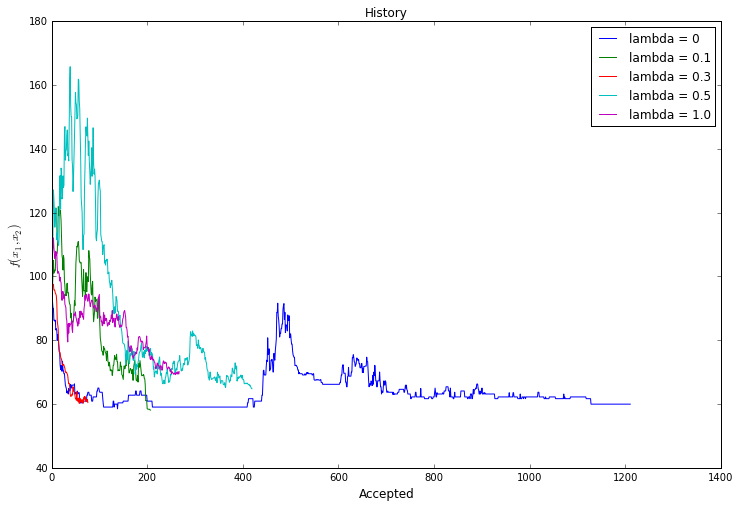

In [16]:
plt.figure(figsize=(12,8))
plt.plot(history, label="lambda = 0")
plt.plot(history4, label="lambda = 0.1")
plt.plot(history3,label="lambda = 0.3")
plt.plot(history2,label="lambda = 0.5")
plt.plot(history5,label="lambda = 1.0")
plt.legend()
plt.title("History")
plt.ylabel("$f(x_1,x_2)$",fontsize=12)
plt.xlabel("Accepted", fontsize=12)
# plt.show()
plt.savefig('lambda01.pdf',bbox_inches='tight', pad_inches=0)


###North Carolina

In [14]:
def swapnodes(nodes, graph):
    indices = range(len(nodes))
    
    # take a random index to swap from the nodes
    n1 = np.random.choice(indices, 1)
    swapped_node = nodes[n1[0]]
    
    # take a random index to swap from the whole graph
    n2 = np.random.choice(graph.nodes(), 1)
        
    # We check that we are not choosing the same node we just swapped
    while n2 == swapped_node:
        n2 = np.random.choice(graph.nodes(), 1)
    
    nodes[n1] = n2[0]
    
    return nodes

In [17]:
def activateNodesOptSA(graph, detStartNodes, t=999999):
    """
    Determines the number of nodes that are activated from pre-specified starting nodes.

    Inputs:
    graph: the NetworkX graph that is explored in the function
    detStartNodes: a list of pre-specific starting nodes
    t: the maximum depth explored from the starting nodes

    Outputs: the number of activated nodes
    """
    
    explored = set()
    activated = set()
    nodes = []
    for node in detStartNodes:
        nodes.append(node)
        activated.add(node)
    
    start = detStartNodes[0]
    successors = []

    for i in range(t):
        successors = []
        while len(nodes)>0:
            startNode = nodes[0]
            if startNode not in explored:
                explored.add(startNode)
            for succNode in graph.succ[startNode]:
                if succNode not in activated:
                    alpha = graph[startNode][succNode]['weight']
                    beta = graph.node[succNode]['review_count']
                    if random.uniform(0,1) < np.sqrt(random.beta(alpha, beta)):
                        if succNode not in explored:
                            activated.add(succNode)
                            successors.append(succNode)
            nodes.remove(startNode)
        nodes = successors
        if not nodes:
            break
    return float(len(activated))


def activateNodesLoopSA(graph, N, startNodes,t):

    iterations = sc.parallelize(xrange(N), 4)
    activatedNodes = iterations.map(lambda x: (activateNodesOptSA(graph,startNodes,t)))
    
    return activatedNodes.mean()

In [18]:
def simulated_annealing_tsp(function, initial_X, graph, N, initial_temp, cool, reanneal, iterr, t):
    
    accepted = 0
    X = initial_X
    T = initial_temp
    
    history = list()
    # Evaluate E
    #print distance(X)
    prev_E = function(graph, N, X, t)
    history.append(prev_E)
    
    for i in xrange(iterr):
        # Stepsize
        L = int(np.ceil(T))
        # Propose new x1 and x2 - Metropolis Algo.
        X_star = swapnodes(X, graph)
        # Evaluate E
        new_E = function(graph, N, X_star, t) 
        delta_E = prev_E - new_E
        
        # Flip a coin
        U = np.random.uniform()
        if U < np.exp(-delta_E / T):
            accepted += 1
            history.append(new_E)
            # Copy X_star to X
            X = X_star
            prev_E = new_E

        # Check to cool down
        if accepted % reanneal == 0:
            T *= cool
            if T < 0.001: # Reheat
                T = 2.
            
    return X, history

###NC_mini

In [ ]:
startNodes = random.choice(NC_digraph_mini.nodes(),3)
initial_temp = 1.5
cool = 0.9
reanneal = 100
iterr = 500
N = 500
t = 10
path, history = simulated_annealing_tsp(activateNodesLoopSA, startNodes, NC_digraph_mini, N,  initial_temp, cool, reanneal, iterr, t)

In [ ]:
print path
plt.figure(figsize=(12,8))
plt.plot(history)
plt.title("History")
plt.ylabel("$f(x_1,x_2)$",fontsize=12)
plt.xlabel("Accepted", fontsize=12)
plt.show()

###NC_full

In [24]:
startNodes = random.choice(NC_digraph_full.nodes(),3)
initial_temp = 2.5
cool = 0.9
reanneal = 100
iterr = 100
N = 500
t = 10
path, history = simulated_annealing_tsp(activateNodesLoopSA, startNodes, NC_digraph_full, N,  initial_temp, cool, reanneal, iterr, t)

In [ ]:
print path
plt.figure(figsize=(12,8))
plt.plot(history)
plt.title("History")
plt.ylabel("$f(x_1,x_2)$",fontsize=12)
plt.xlabel("Accepted", fontsize=12)
plt.show()